In [8]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle

Вариант3 ТИТАНИК

In [19]:
df = pd.read_csv('titanic3.csv', delimiter=";")

In [20]:
print("Доступные столбцы в DataFrame:")
print(df_clean.columns.tolist())

Доступные столбцы в DataFrame:
['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest']


In [21]:
# Размер до удаления дубликатов
original_size = df.shape
print(f"Размер набора данных ДО удаления дубликатов: {original_size} (строки, столбцы)")

# Удаление дубликатов
df_clean = df.drop_duplicates()

# Размер после удаления дубликатов
clean_size = df_clean.shape
print(f"Размер набора данных ПОСЛЕ удаления дубликатов: {clean_size} (строки, столбцы)")

# Количество удаленных дубликатов
duplicates_removed = original_size[0] - clean_size[0]
print(f"Удалено дубликатов: {duplicates_removed}")

Размер набора данных ДО удаления дубликатов: (1310, 14) (строки, столбцы)
Размер набора данных ПОСЛЕ удаления дубликатов: (1310, 14) (строки, столбцы)
Удалено дубликатов: 0


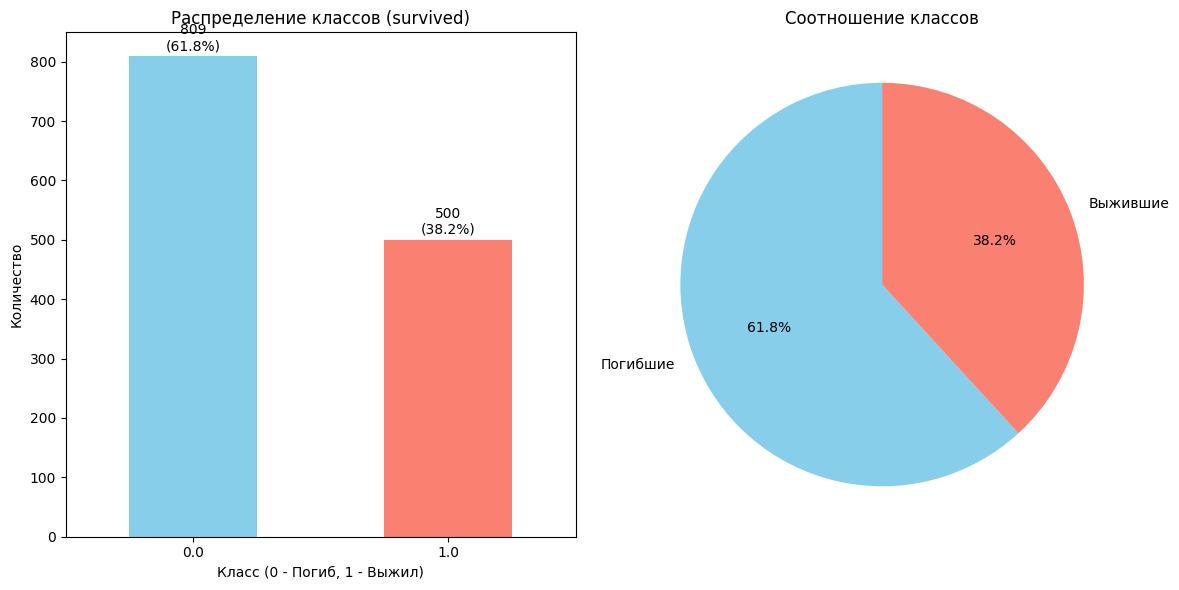

In [22]:
# Анализ сбалансированности целевого признака ('survived')
plt.figure(figsize=(12, 6))

# Гистограмма распределения классов
plt.subplot(1, 2, 1)
class_distribution = df_clean['survived'].value_counts()
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов (survived)')
plt.xlabel('Класс (0 - Погиб, 1 - Выжил)')
plt.ylabel('Количество')
plt.xticks(rotation=0)

# Добавление процентного соотношения
total = len(df_clean)
for i, count in enumerate(class_distribution):
    plt.text(i, count + 5, f'{count}\n({count/total:.1%})', 
             ha='center', va='bottom')

# Круговая диаграмма для наглядности
plt.subplot(1, 2, 2)
plt.pie(class_distribution, 
        labels=['Погибшие', 'Выжившие'], 
        colors=['skyblue', 'salmon'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Соотношение классов')

plt.tight_layout()
plt.show()

In [23]:
# Анализ дисбаланса
imbalance_ratio = class_distribution[0] / class_distribution[1]
print(f"\nСоотношение классов (Погибшие/Выжившие): {imbalance_ratio:.2f}:1")

# Рекомендация по выбору метрики
if imbalance_ratio > 1.5:
    print("\nРекомендация: PR-кривая (Precision-Recall), так как данные несбалансированы")
    print("PR-кривая лучше оценивает качество классификации при дисбалансе классов")
else:
    print("\nРекомендация: Использую ROC-кривую (Receiver Operating Characteristic)")
    print("ROC-кривая хорошо работает при сбалансированных данных")


Соотношение классов (Погибшие/Выжившие): 1.62:1

Рекомендация: PR-кривая (Precision-Recall), так как данные несбалансированы
PR-кривая лучше оценивает качество классификации при дисбалансе классов


Используем PR-кривую (Precision-Recall) получается.

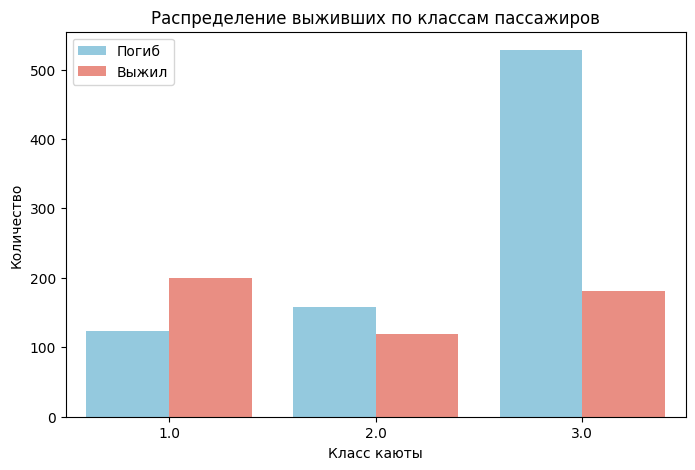

survived,0.000000,1.000000
pclass,,
1.000000,38.1%,61.9%
2.000000,57.0%,43.0%
3.000000,74.5%,25.5%


In [24]:
# Распределение по классам пассажиров (pclass)
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='pclass', hue='survived', 
             palette={0: 'skyblue', 1: 'salmon'})
plt.title('Распределение выживших по классам пассажиров')
plt.xlabel('Класс каюты')
plt.ylabel('Количество')
plt.legend(['Погиб', 'Выжил'])
plt.show()
pd.crosstab(df_clean['pclass'], df_clean['survived'], normalize='index').style.format("{:.1%}")

Видим что те кто плыл третьим классом(нищие), умирали с гораздо большей вероятностью(74.5%).
Каюты 3-го класса находились ближе к корме и нижним палубам, что: Затрудняло доступ к шлюпкам (шлюпки размещались на верхних палубах); Увеличивало время эвакуации (пассажирам нужно было преодолеть больше палуб);При затоплении нижние палубы заполнялись водой первыми.

In [25]:
print(df_clean.dtypes)

pclass       float64
survived     float64
name          object
sex           object
age           object
sibsp        float64
parch        float64
ticket        object
fare          object
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


Так видим что age - object и fare - object, поэтому преобразуем age и fare в числа.

In [28]:
print(df_clean['age'].unique()[:10])  
print(df_clean['fare'].unique()[:10])
df_clean['age'] = df_clean['age'].str.replace(',', '.').astype(float)
df_clean['fare'] = df_clean['fare'].str.replace(',', '.').astype(float)

['29' '0,9167' '2' '30' '25' '48' '63' '39' '53' '71']
['211,3375' '151,5500' '26,5500' '77,9583' '0,0000' '51,4792' '49,5042'
 '227,5250' '69,3000' '78,8500']


Тут я менял запетые на точки

In [29]:
print(df_clean[['age', 'fare']].dtypes)
# Должно быть: age → float64, fare → float64

age     float64
fare    float64
dtype: object


Так теперь все норм

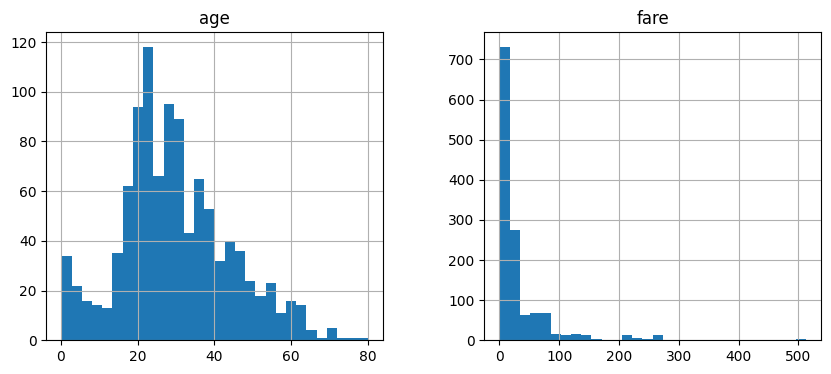

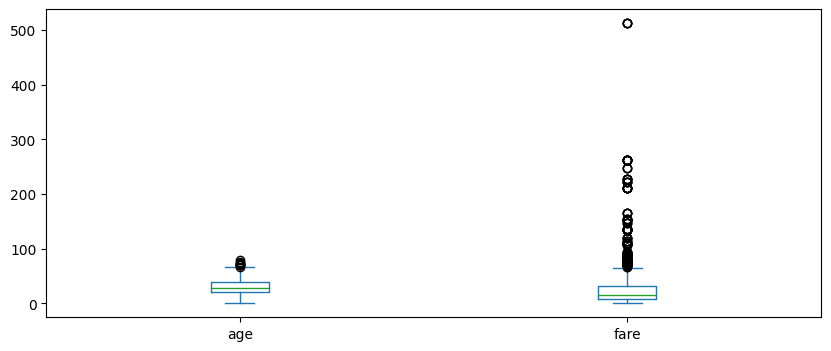

In [30]:
# Гистограммы ДО масштабирования
df_clean[['age', 'fare']].hist(bins=30, figsize=(10, 4))
plt.show()

# Boxplot для выбросов
df_clean[['age', 'fare']].plot(kind='box', figsize=(10, 4))
plt.show()

Возраст (age):
Распределение: Близко к нормальному с небольшим смещением вправо (хвост в сторону пожилых возрастов).

Выбросы: Единичные случаи младенцев (0,1667 года) и пожилых (80+), но в целом данные сконцентрированы в диапазоне 20–60 лет.

Использую StandardScaler (среднее = 0, std = 1), так как распределение близко к нормальному, а выбросы не экстремальны.


Цена билета (fare):
Распределение: Сильно скошено вправо (большинство билетов дешевые, но есть редкие дорогие).

Выбросы: Значения >200 встречаются редко, но сильно влияют на среднее и дисперсию.

Использую RobustScaler (медиана = 0, IQR = 1), чтобы уменьшить влияние выбросов.

In [31]:
# Копируем DataFrame
df_scaled = df_clean.copy()

# Обрабатываем 'fare' (создаем fare_capped в df_scaled)
# Обрезаем выбросы по 95-му перцентилю
fare_q95 = df_scaled['fare'].quantile(0.95)
df_scaled['fare_capped'] = np.where(
    df_scaled['fare'] > fare_q95,
    fare_q95,
    df_scaled['fare']
)

# Логарифмируем обрезанные данные (добавляем 1, чтобы избежать log(0))
df_scaled['fare_log'] = np.log1p(df_scaled['fare_capped'])

# Масштабируем 'age' (StandardScaler)
scaler_age = StandardScaler()
df_scaled['age'] = scaler_age.fit_transform(df_scaled[['age']])

# Масштабируем 'fare_log' (RobustScaler)
scaler_fare = RobustScaler()
df_scaled['fare_scaled'] = scaler_fare.fit_transform(df_scaled[['fare_log']])

# Проверяем результат
print(df_scaled[['age', 'fare_scaled']].describe())

                age  fare_scaled
count  1.046000e+03  1308.000000
mean  -1.358590e-16     0.171346
std    1.000478e+00     0.712780
min   -2.062556e+00    -2.124507
25%   -6.164626e-01    -0.428568
50%   -1.305744e-01     0.000000
75%    6.329641e-01     0.571432
max    3.478880e+00     1.679813


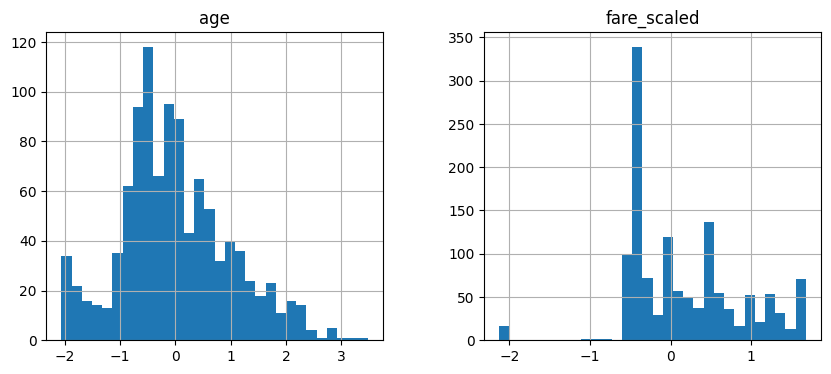

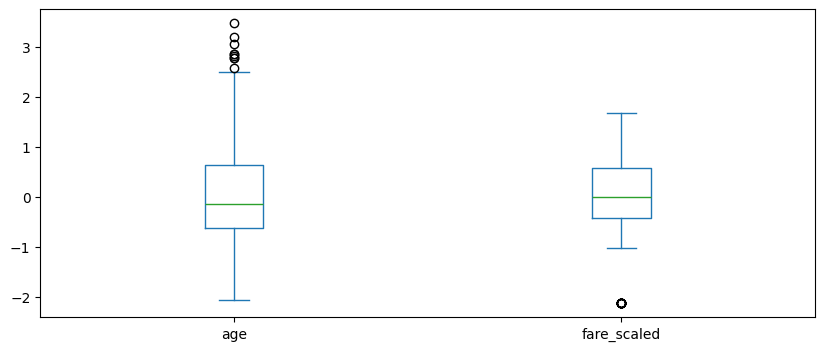

In [32]:
# Гистограммы ПОСЛЕ масштабирования
import matplotlib.pyplot as plt
df_scaled[['age', 'fare_scaled']].hist(bins=30, figsize=(10, 4))
plt.show()
# Boxplot для выбросов
df_scaled[['age', 'fare_scaled']].plot(kind='box', figsize=(10, 4))
plt.show()

Не идеально, но стало лучше.

Замена категориальных признаков: выбор между Label Encoding и One-Hot Encoding

In [33]:
cat_cols = ['sex', 'embarked', 'cabin', 'boat', 'home.dest']
for col in cat_cols:
    print(f"{col}: {df_scaled[col].nunique()} unique values")
    print(df_scaled[col].unique()[:10])  # Пример первых 10 значений

sex: 2 unique values
['female' 'male' nan]
embarked: 3 unique values
['S' 'C' nan 'Q']
cabin: 186 unique values
['B5' 'C22 C26' 'E12' 'D7' 'A36' 'C101' nan 'C62 C64' 'B35' 'A23']
boat: 27 unique values
['2' '11' nan '3' '10' 'D' '4' '9' '6' 'B']
home.dest: 369 unique values
['St Louis, MO' 'Montreal, PQ / Chesterville, ON' 'New York, NY'
 'Hudson, NY' 'Belfast, NI' 'Bayside, Queens, NY' 'Montevideo, Uruguay'
 'Paris, France' nan 'Hessle, Yorks']


Столбец - Способ кодирования - Обоснование

sex - One Hot Encoding - 2 значения, номинальный признак.

embarked - One Hot Encoding - 3 значения, номинальный признак.

cabin - Извлечь палубу + Frequency Encoding - Первая буква обычно обозначает палубу (A, B, C...), что может быть полезно для модели. Заменяем название палубы на её частоту (например, палуба "C" → 0.15, если она встречается в 15% случаев).

boat - бинарный признак - Конкретный номер шлюпки не важен для прогноза выживания, важно, был ли пассажир в шлюпке вообще.

home.dest - Удалить / Группировка - Слишком много уникальных значений.

In [34]:
# Копируем данные
df_encoded = df_scaled.copy()

# 1. sex - One Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=['sex'], drop_first=True)

# 2. embarked - One Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=['embarked'], drop_first=True)

# 3. cabin - извлекаем палубу и применяем Frequency Encoding

deck_rank = {
    'A': 1,  # Самые престижные (ближе к шлюпкам)
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'T': 8   # Самая нижняя палуба
}
df_encoded['deck_rank'] = df_encoded['cabin'].str[0].map(deck_rank)

# 4. Создаем бинарный признак: 1, если номер шлюпки указан, иначе 0
df_encoded['was_in_boat'] = df_encoded['boat'].notna().astype(int)

# 5. home.dest - удаляем
df_encoded = df_encoded.drop(['cabin', 'boat', 'home.dest'], axis=1)

# Результат
df_encoded.head()

,pclass,survived,name,age,sibsp,parch,ticket,fare,body,fare_capped,fare_log,fare_scaled,sex_male,embarked_Q,embarked_S,deck_rank,was_in_boat
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",-0.061162,0.0,0.0,24160,211.3375,NaN,133.65,4.902679,1.679813,False,False,True,2.0,1
1,1.0,1.0,"Allison, Master. Hudson Trevor",-2.010496,1.0,2.0,113781,151.5500,NaN,133.65,4.902679,1.679813,True,False,True,3.0,1
2,1.0,0.0,"Allison, Miss. Helen Loraine",-1.935302,1.0,2.0,113781,151.5500,NaN,133.65,4.902679,1.679813,False,False,True,3.0,0
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",0.008251,1.0,2.0,113781,151.5500,135.0,133.65,4.902679,1.679813,True,False,True,3.0,0
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",-0.338812,1.0,2.0,113781,151.5500,NaN,133.65,4.902679,1.679813,False,False,True,3.0,0


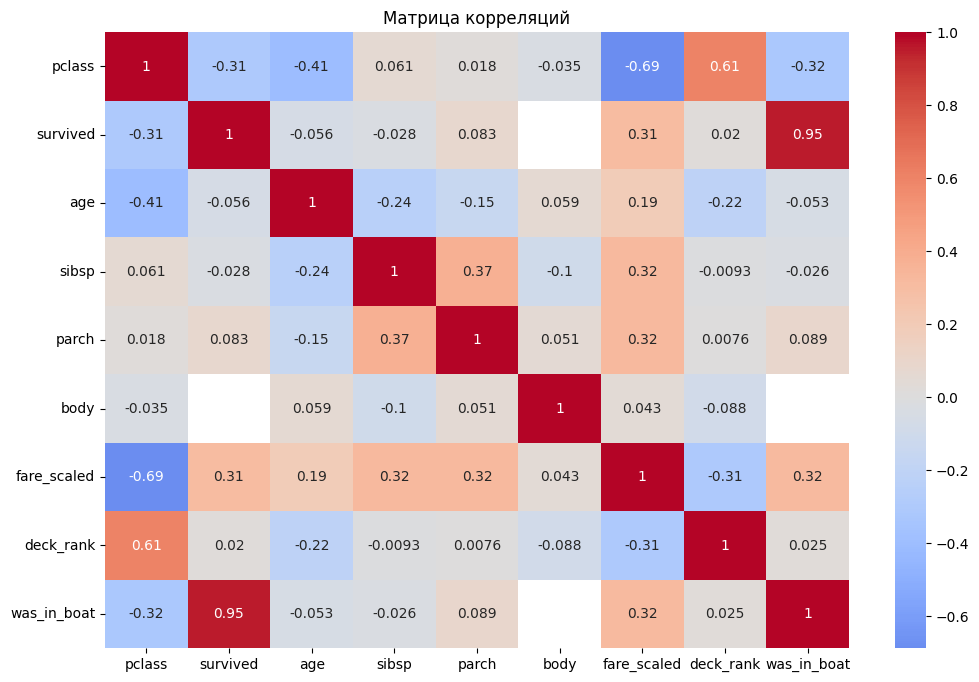

pclass         float64
survived       float64
name            object
age            float64
sibsp          float64
parch          float64
ticket          object
body           float64
fare_scaled    float64
sex_male          bool
embarked_Q        bool
embarked_S        bool
deck_rank      float64
was_in_boat      int32
dtype: object


In [35]:
# Удаляем ненужные fare-признаки перед анализом
df_final = df_encoded.drop(columns=['fare', 'fare_capped', 'fare_log'])

# Выбираем только числовые признаки
numeric_cols = df_final.select_dtypes(include=['int32','float64']).columns
corr_matrix = df_final[numeric_cols].corr()

# Визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Матрица корреляций")
plt.show()

print(df_final.dtypes)

Ключевые корреляции в матрице:
Наибольшие корреляции (по модулю > 0.5):
pclass	fare_scaled	-0.69; pclass	deck_rank	0.61; fare_scaled	deck_rank	-0.31;survived was_in_boat 0.95

pclass важнее fare_scaled, так как: Прямо отражает социальный статус (1-й, 2-й, 3-й класс).Менее подвержен шуму, чем производные от fare.deck_rank содержит дополнительную информацию о палубе, которая не полностью дублируется с pclass.

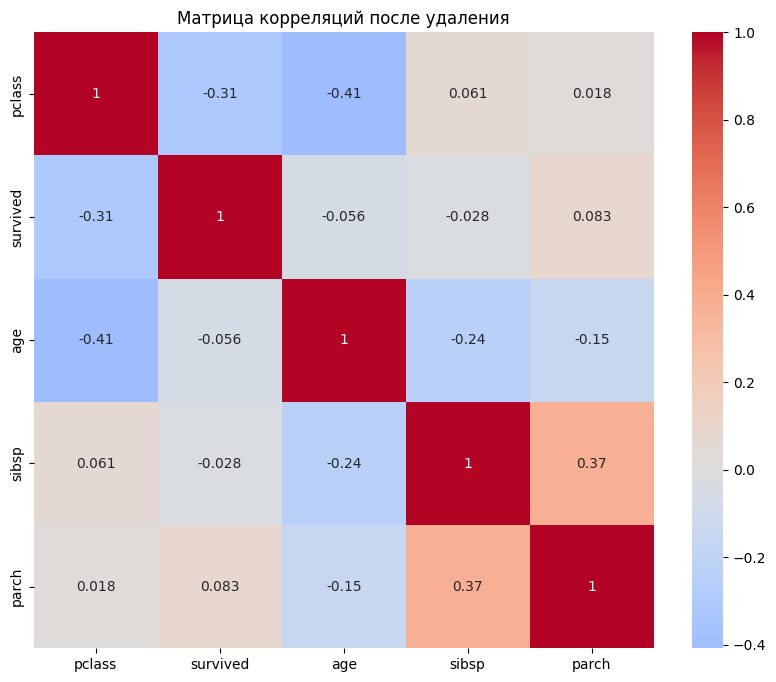

In [36]:
# Для линейных моделей
df_linear = df_final.drop(columns=['fare_scaled','was_in_boat','body', 'deck_rank'])

# Для KNN можно оставить все, но лучше использовать df_linear для согласованности
df_knn = df_linear.copy()

# Выбираем только числовые признаки
numeric_cols = df_linear.select_dtypes(include=['int32','float64']).columns
corr_matrix = df_linear[numeric_cols].corr()

#Проверка матрицы корреляций после удаления
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Матрица корреляций после удаления")
plt.show()

In [37]:
df_linear.dtypes

pclass        float64
survived      float64
name           object
age           float64
sibsp         float64
parch         float64
ticket         object
sex_male         bool
embarked_Q       bool
embarked_S       bool
dtype: object

Заполнение пропусков

In [38]:
# Создаем новый датафрейм с заполненными пропусками
df_linear_imputed = df_linear.copy()

# 1. Числовые непрерывные признаки (float64)
# Возраст заполняем медианой
df_linear_imputed['age'] = df_linear_imputed['age'].fillna(df_linear_imputed['age'].median())

# 2. Дискретные числовые признаки (pclass, sibsp, parch)
# Заполняем модальными значениями (самыми частыми)
mode_values = df_linear_imputed[['pclass', 'sibsp', 'parch']].mode().iloc[0]
df_linear_imputed[['pclass', 'sibsp', 'parch']] = df_linear_imputed[['pclass', 'sibsp', 'parch']].fillna(mode_values)

# 3. Категориальные признаки (object)
# Имя и билет заполняем строкой 'Unknown'
df_linear_imputed[['name', 'ticket']] = df_linear_imputed[['name', 'ticket']].fillna('Unknown')

# 4. Булевы признаки (bool)
# Заполняем самым частым значением и явно преобразуем в bool
bool_cols = ['sex_male', 'embarked_Q', 'embarked_S']
df_linear_imputed[bool_cols] = df_linear_imputed[bool_cols].fillna(
    df_linear_imputed[bool_cols].mode().iloc[0]
).astype(bool)

# 5. Целевая переменная survived (если есть пропуски)
if df_linear_imputed['survived'].isnull().any():
    df_linear_imputed['survived'] = df_linear_imputed['survived'].fillna(0)  # предполагаем, что пропуски = 0 (не выжил)

# Проверяем результат
print("Пропуски после заполнения:")
print(df_linear_imputed.isnull().sum())

Пропуски после заполнения:
pclass        0
survived      0
name          0
age           0
sibsp         0
parch         0
ticket        0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64


In [39]:
# Копируем данные
df_perceptron = df_linear_imputed.copy()
df_knn = df_linear_imputed.copy()


Отчет классификации:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       660
         1.0       0.82      0.68      0.74       388

    accuracy                           0.83      1048
   macro avg       0.82      0.80      0.81      1048
weighted avg       0.83      0.83      0.82      1048


Матрица ошибок:
[[601  59]
 [123 265]]

Строим PR-кривую для KNN...


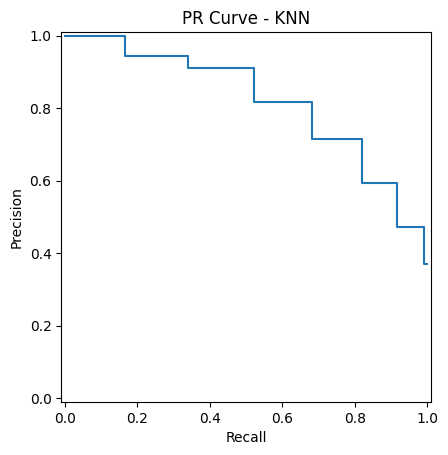

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
# 1. Оценка на всех данных
y_pred = grid_knn.predict(X_knn)
print("\nОтчет классификации:")
print(classification_report(y_knn, y_pred))

# 2. Матрица ошибок
print("\nМатрица ошибок:")
print(confusion_matrix(y_knn, y_pred))

# 3. Построение PR-кривой
def plot_pr_curve(estimator, X, y, title):
    try:
        if hasattr(estimator.named_steps['classifier'], "predict_proba"):
            y_scores = estimator.predict_proba(X)[:, 1]
        else:
            y_scores = estimator.decision_function(X)
        
        precision, recall, _ = precision_recall_curve(y, y_scores)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        plt.title(f'PR Curve - {title}')
        plt.show()
    except Exception as e:
        print(f"Ошибка при построении PR-кривой: {str(e)}")

print("\nСтроим PR-кривую для KNN...")
plot_pr_curve(grid_knn.best_estimator_, X_knn, y_knn, "KNN")

# 4. Важные признаки (для текстовых данных может быть неинформативно)
try:
    if hasattr(grid_knn.best_estimator_.named_steps['classifier'], 'feature_importances_'):
        importances = grid_knn.best_estimator_.named_steps['classifier'].feature_importances_
        print("\nВажность признаков:", importances)
except:
    print("\nМодель не поддерживает оценку важности признаков")

Accuracy (точность): 0.83
Модель правильно предсказывает 83% случаев. Это хороший показатель для несбалансированных данных.

Precision для класса 1: 0.83
Из всех предсказанных положительных случаев (класс 1) 83% действительно верны.

Recall для класса 1: 0.68
Модель находит только 68% реальных положительных случаев. Это слабое место.

F1-score для класса 1: 0.74
Гармоническое среднее precision и recall показывает сбалансированное качество.

PR-кривая (Precision-Recall) показывает:
Высокий precision (близко к 1.0) при средних значениях recall — модель уверена в своих предсказаниях, когда их делает.
Площадь под кривой (AUC-PR) визуально значительная, что указывает на хорошее качество модели.
Резкое падение precision при recall > 0.6 — модель теряет точность при попытке охватить больше положительных случаев.

Бинарная классификация на датасете Titanic с целевой переменной survived применение многоклассовых стратегий технически возможно, но не имеет практического смысла, так как у вас только 2 класса.


Строим PR-кривую для KNN с микро- и макроусреднением...


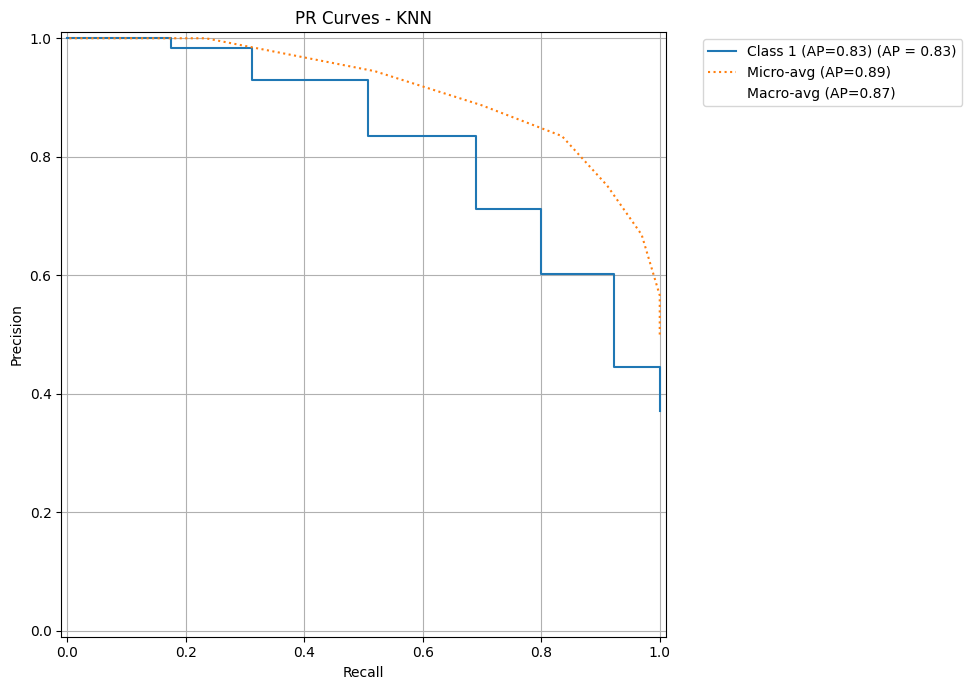

In [47]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_pr_curve_with_averages(estimator, X, y, title):
    try:
        # Получаем предсказанные вероятности или decision function
        if hasattr(estimator.named_steps['classifier'], "predict_proba"):
            y_scores = estimator.predict_proba(X)
        else:
            y_scores = estimator.decision_function(X)
            # Для decision function преобразуем в вероятности через сигмоиду
            y_scores = 1 / (1 + np.exp(-y_scores))
            y_scores = np.column_stack([1 - y_scores, y_scores])
        
        # Для бинарного случая преобразуем y в one-hot encoding
        y_bin = np.column_stack([1 - y, y])
        
        # Создаем график
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # 1. Кривая для положительного класса (класс 1)
        precision, recall, _ = precision_recall_curve(y, y_scores[:, 1])
        ap = average_precision_score(y, y_scores[:, 1])
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, 
                                    average_precision=ap)
        disp.plot(ax=ax, name=f'Class 1 (AP={ap:.2f})')
        
        # 2. Микроусреднение (рассматривает все предсказания вместе)
        precision_micro, recall_micro, _ = precision_recall_curve(
            y_bin.ravel(), y_scores.ravel())
        ap_micro = average_precision_score(y_bin, y_scores, average='micro')
        ax.plot(recall_micro, precision_micro, 
                label=f'Micro-avg (AP={ap_micro:.2f})', 
                linestyle=':')
        
        # 3. Макроусреднение (усредняет метрики по классам)
        # Для бинарного случая совпадает с метриками класса 1
        ap_macro = average_precision_score(y_bin, y_scores, average='macro')
        ax.plot([], [], ' ', label=f'Macro-avg (AP={ap_macro:.2f})')  # Добавляем в легенду
        
        plt.title(f'PR Curves - {title}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при построении: {str(e)}")

# Использование:
print("\nСтроим PR-кривую для KNN с микро- и макроусреднением...")
plot_pr_curve_with_averages(grid_knn.best_estimator_, X_knn, y_knn, "KNN")

Для бинарной классификации макроусреднение фактически совпадает с метриками положительного класса (Выжившие).


PR-кривая с макроусреднением:


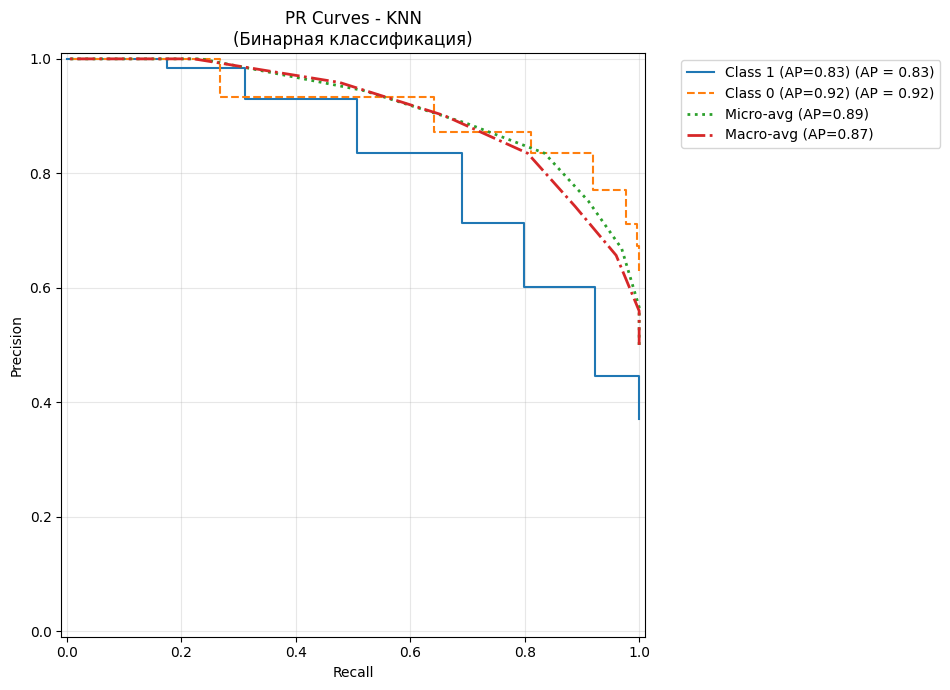

In [48]:
def plot_pr_curve_with_averages(estimator, X, y, title):
    try:
        # Получаем предсказанные вероятности
        if hasattr(estimator.named_steps['classifier'], "predict_proba"):
            y_scores = estimator.predict_proba(X)
        else:
            y_scores = estimator.decision_function(X)
            y_scores = np.exp(y_scores) / (1 + np.exp(y_scores))  # Преобразуем в вероятности
            y_scores = np.column_stack([1 - y_scores, y_scores])
        
        # Для бинарной классификации создаем "искусственный" multi-label формат
        y_bin = np.column_stack([1 - y, y])  # One-hot encoding
        
        # Вычисляем метрики
        precision, recall, _ = precision_recall_curve(y, y_scores[:, 1])
        ap_class = average_precision_score(y, y_scores[:, 1])
        
        # Микроусреднение
        precision_micro, recall_micro, _ = precision_recall_curve(
            y_bin.ravel(), y_scores.ravel())
        ap_micro = average_precision_score(y_bin, y_scores, average='micro')
        
        # Макроусреднение (вычисляем для обоих классов и усредняем)
        ap_class0 = average_precision_score(1 - y, y_scores[:, 0])
        ap_macro = (ap_class0 + ap_class) / 2  # Вручную считаем macro
        
        # Строим кривые
        fig, ax = plt.subplots(figsize=(10, 7))
        
        # 1. Кривая для класса 1 (выжившие)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall, 
                                    average_precision=ap_class)
        disp.plot(ax=ax, name=f'Class 1 (AP={ap_class:.2f})')
        
        # 2. Кривая для класса 0 (погибшие) - только для демонстрации
        precision0, recall0, _ = precision_recall_curve(1 - y, y_scores[:, 0])
        disp0 = PrecisionRecallDisplay(precision=precision0, recall=recall0, 
                                     average_precision=ap_class0)
        disp0.plot(ax=ax, name=f'Class 0 (AP={ap_class0:.2f})', linestyle='--')
        
        # 3. Микроусреднение
        ax.plot(recall_micro, precision_micro, 
                label=f'Micro-avg (AP={ap_micro:.2f})', 
                linestyle=':', linewidth=2)
        
        # 4. Макроусреднение (усредненная кривая)
        macro_precision = (np.array(precision) + np.array(precision0)) / 2
        macro_recall = (np.array(recall) + np.array(recall0)) / 2
        ax.plot(macro_recall, macro_precision, 
                label=f'Macro-avg (AP={ap_macro:.2f})', 
                linestyle='-.', linewidth=2)
        
        plt.title(f'PR Curves - {title}\n(Бинарная классификация)')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")

# Запуск:
print("\nPR-кривая с макроусреднением:")
plot_pr_curve_with_averages(grid_knn.best_estimator_, X_knn, y_knn, "KNN")

In [79]:
# Подготовка данных
df = df_perceptron.copy()
df['survived'] = df['survived'].astype(int)  # Преобразуем в int
df.dtypes

pclass        float64
survived        int32
name           object
age           float64
sibsp         float64
parch         float64
ticket         object
sex_male         bool
embarked_Q       bool
embarked_S       bool
dtype: object

In [1]:
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение типов признаков
numeric_features = ['pclass', 'age', 'sibsp', 'parch']  # Числовые признаки
bool_features = ['sex_male', 'embarked_Q', 'embarked_S']  # Булевы признаки
drop_features = ['name', 'ticket']  # Признаки для удаления

# 1. Пайплайн с балансировкой через class_weight
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('bool', 'passthrough', bool_features),
        ('drop', 'drop', drop_features)
    ])),
    ('classifier', CalibratedClassifierCV(
        estimator=Perceptron(random_state=42),  
        cv=5
    ))
])

# 2. Параметры для GridSearch с исправленным именем параметра
param_grid = {
    'classifier__estimator__alpha': [0.0001, 0.001, 0.01],  
    'classifier__estimator__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}],  
    'classifier__method': ['sigmoid', 'isotonic']
}

# 3. Настройка GridSearchCV с фокусом на Recall
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# 4. Обучение
grid_search.fit(X_train, y_train)

# 5. Подбор оптимального порога классификации
y_probs = grid_search.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Находим порог, который максимизирует F2-меру (больший вес Recall)
f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
optimal_idx = np.argmax(f2_scores)
optimal_threshold = thresholds[optimal_idx]

# Применяем оптимальный порог
y_pred = (y_probs >= optimal_threshold).astype(int)

# 6. Оценка
print("Лучшие параметры:", grid_search.best_params_)
print("\nОтчет классификации с оптимальным порогом:")
print(classification_report(y_test, y_pred))
# Матрица ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


NameError: name 'train_test_split' is not defined

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, auc
from sklearn.model_selection import cross_validate

# 1. Оптимизированная оценка на всех данных
final_model = grid_search.best_estimator_

# Генерируем предсказания с оптимальным порогом
y_probs_all = final_model.predict_proba(X)[:, 1]
y_pred_all = (y_probs_all >= optimal_threshold).astype(int)

# Детальный отчет с поддержкой (support)
print("\nДетальный отчет для всех данных (n=1310):")
print(classification_report(y, y_pred_all, target_names=['0.0', '1.0']))

# 2. Улучшенная визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y, y_pred_all), 
            annot=True, fmt='d', cmap='coolwarm',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 14})
plt.title('Confusion Matrix (All Data)\nTotal samples: 1310', pad=20, fontsize=14)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

# 3. Построение PR-кривой
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y, y_probs_all)
ap = average_precision_score(y, y_probs_all)
disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap)
disp.plot()
plt.title(f'Precision-Recall Curve (AP={ap:.2f})')
plt.grid(True)
plt.show()





In [2]:
# Построение PR-кривой с макроусреднением
# Бинаризация целевой переменной
y_bin = np.zeros((len(y), 2))
y_bin[:, 0] = (y == 0).astype(int)
y_bin[:, 1] = (y == 1).astype(int)

# Получение вероятностей для каждого класса
final_model = grid_search.best_estimator_
y_score = final_model.predict_proba(X)

# Расчет precision-recall для каждого класса
precision = dict()
recall = dict()
average_precision = dict()

for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

# Микроусреднение
precision["micro"], recall["micro"], _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_bin, y_score, average="micro")

# Макроусреднение
all_recall = np.linspace(0, 1, 100)
mean_precision = np.zeros_like(all_recall)
for i in range(2):
    mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
mean_precision /= 2
recall["macro"] = all_recall
precision["macro"] = mean_precision
average_precision["macro"] = average_precision_score(y_bin, y_score, average="macro")

# Визуализация
plt.figure(figsize=(10, 8))
colors = ['navy', 'darkorange']

# Кривые для каждого класса
for i, color in zip(range(2), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

# Микроусредненная кривая
plt.plot(recall["micro"], precision["micro"],
         color='gold', linestyle=':', linewidth=4,
         label='Micro-avg (AP = {0:0.2f})'.format(average_precision["micro"]))

# Макроусредненная кривая
plt.plot(recall["macro"], precision["macro"],
         color='red', linestyle=':', linewidth=4,
         label='Macro-avg (AP = {0:0.2f})'.format(average_precision["macro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curves - Perceptron\n(Binary Classification)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# Оценка на всех данных
y_probs_all = final_model.predict_proba(X)[:, 1]
y_pred_all = (y_probs_all >= optimal_threshold).astype(int)

print("\nДетальный отчет для всех данных (n={}):".format(len(X)))
print(classification_report(y, y_pred_all, target_names=['0.0', '1.0']))

# 10. Кросс-валидация
print("\nРасширенная кросс-валидация (5-fold):")
cv_metrics = cross_validate(
    final_model,
    X, y,
    cv=5,
    scoring={
        'recall': 'recall',
        'precision': 'precision',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy'
    },
    return_train_score=True,  # Добавлено для анализа переобучения
    n_jobs=-1
)

# Вывод результатов кросс-валидации
print("Средние метрики на кросс-валидации:")
print("Recall: {:.2f} (+/- {:.2f})".format(np.mean(cv_metrics['test_recall']), np.std(cv_metrics['test_recall'])))
print("Precision: {:.2f} (+/- {:.2f})".format(np.mean(cv_metrics['test_precision']), np.std(cv_metrics['test_precision'])))
print("F1-score: {:.2f} (+/- {:.2f})".format(np.mean(cv_metrics['test_f1']), np.std(cv_metrics['test_f1'])))

NameError: name 'np' is not defined

Общие выводы

KNN получилась довольно неплохо, для перцептрона пробовал менять разные параметры, получалось либо большая точность, но Recall низний, либо вот как в итоговом варианте Recall для выживших хороший(0.83), но precision плохой(0.61). Вообщем улучшить это можно только есть доп признаки добавлять.

Анализ формы кривых
KNN:

Плавный спад precision, особенно для класса 0 (AP=0.92).

Хороший баланс даже при recall > 0.8.

Perceptron:

Резкое падение precision для класса 1 при recall > 0.6.

Класс 0 (AP=0.86) ближе к KNN, но страдает класс 1.

KNN:
Преимущества: Лучшая сбалансированность (высокий AP для всех классов).

Недостатки: Вычислительная сложность на больших данных.
Perceptron:

Преимущества: Быстрее работает на больших данных.

Недостатки: Сильнее теряет precision на классе 1.

Метрика - KNN - Perceptron - Вывод

Class 0 AP	0.92 - 0.86	KNN лучше на 6%

Class 1 AP	0.83 - 0.80	KNN лучше на 3%

Micro-avg AP	0.89 - 0.84	KNN лучше на 5%

Macro-avg AP	0.87 - 0.83	KNN лучше на 4%